In [1]:
!pip install nnabla-ext-cuda100
!git clone https://github.com/sony/nnabla-examples.git
%run nnabla-examples/interactive-demos/colab_utils.py
%cd nnabla-examples/image-translation/stargan

     |████████████████████████████████| 51.1 MB 200 kB/s 
     |████████████████████████████████| 18.1 MB 407 kB/s 
     |████████████████████████████████| 132 kB 34.2 MB/s 
     |████████████████████████████████| 8.6 MB 28.8 MB/s 
     |████████████████████████████████| 79 kB 7.0 MB/s 
     |████████████████████████████████| 138 kB 37.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Cloning into 'nnabla-examples'...
remote: Enumerating objects: 7186, done.
remote: Counting objects: 100% (2950

We need to download the pretrained weight and required config file.

In [2]:
# get StarGAN pretrained weights.
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5

# get StarGAN config file.
!wget https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json

--2022-02-25 03:14:43--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_params_on_celebA.h5
Resolving nnabla.org (nnabla.org)... 108.156.107.65, 108.156.107.116, 108.156.107.87, ...
Connecting to nnabla.org (nnabla.org)|108.156.107.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 212881888 (203M) [binary/octet-stream]
Saving to: ‘pretrained_params_on_celebA.h5’

pretrained_params_o 100%[===================>] 203.02M   150MB/s    in 1.4s    

2022-02-25 03:14:45 (150 MB/s) - ‘pretrained_params_on_celebA.h5’ saved [212881888/212881888]

--2022-02-25 03:14:45--  https://nnabla.org/pretrained-models/nnabla-examples/GANs/stargan/pretrained_conf_on_celebA.json
Resolving nnabla.org (nnabla.org)... 108.156.107.65, 108.156.107.116, 108.156.107.87, ...
Connecting to nnabla.org (nnabla.org)|108.156.107.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 775 [application/json]
Saving to: ‘pretrained_conf_on_celebA.j

# Upload an image

Run the below cell to upload an image to use. Make sure to select just 1 image (if you upload multiple images, all the images but the last one will be ignored) and that image must contain **one** face.

In [22]:
from google.colab import files

img = files.upload()

Saving 황대헌2.jpg to 황대헌2.jpg


For convenience, rename the image file. Also, let's check the input image here.

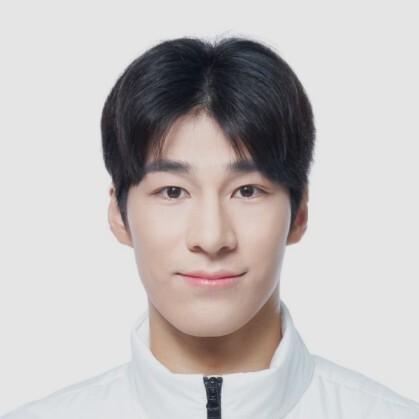

In [23]:
import os
ext = os.path.splitext(list(img.keys())[-1])[-1]
os.rename(list(img.keys())[-1], "input_image{}".format(ext)) 

input_img = "input_image" + ext

from IPython.display import Image,display
display(Image(input_img))

Since the model expects the input images to contain a facial region only, We need to crop the image. This time we use dlib for face detection and cropping. First, we'll download the required dlib weights.

In [24]:
# get dlib's face detection model.
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2
!bzip2 -d mmod_human_face_detector.dat.bz2

--2022-02-25 03:22:50--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2.1’

mmod_human_face_det 100%[===================>] 678.43K  3.29MB/s    in 0.2s    

2022-02-25 03:22:51 (3.29 MB/s) - ‘mmod_human_face_detector.dat.bz2.1’ saved [694709/694709]

bzip2: Output file mmod_human_face_detector.dat already exists.


And then import some dependency.

In [25]:
import cv2
import dlib
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

Now using dlib we'll detect the face in the image.

In [26]:
image = io.imread(input_img)
if image.ndim == 2:
    image = color.gray2rgb(image)
elif image.shape[-1] == 4:
    image = image[..., :3]

face_detector = dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")
detected_faces = face_detector(cv2.cvtColor(image[..., ::-1].copy(), cv2.COLOR_BGR2GRAY))
detected_faces = [[d.rect.left(), d.rect.top(), d.rect.right(), d.rect.bottom()] for d in detected_faces]

assert len(detected_faces) == 1, "Warning: only one face should be contained."
detected_faces = detected_faces[0]

Here, with some scripts, we extract the facial region only. These scripts are from [FAN example](https://github.com/sony/nnabla-examples/tree/master/facial-keypoint-detection/face-alignment), but partially modified.

In [27]:
def transform(point, center, scale, resolution, invert=False):
    """Generate and affine transformation matrix.
    Given a set of points, a center, a scale and a target resolution, the
    function generates and affine transformation matrix. If invert is ``True``
    it will produce the inverse transformation.
    Arguments:
        point {numpy.array} -- the input 2D point
        center {numpy.array} -- the center around which to perform the transformations
        scale {float} -- the scale of the face/object
        resolution {float} -- the output resolution
    Keyword Arguments:
        invert {bool} -- define wherever the function should produce the direct or the
        inverse transformation matrix (default: {False})
    """
    point.append(1)

    h = 200.0 * scale
    t = np.eye(3)
    t[0, 0] = resolution / h
    t[1, 1] = resolution / h
    t[0, 2] = resolution * (-center[0] / h + 0.5)
    t[1, 2] = resolution * (-center[1] / h + 0.5)

    if invert:
        t = np.reshape(np.linalg.inv(np.reshape(t, [1, 3, 3])), [3, 3])

    new_point = np.reshape(np.matmul(
        np.reshape(t, [1, 3, 3]), np.reshape(point, [1, 3, 1])), [3, ])[0:2]

    return new_point.astype(int)


def crop(image, center, scale, resolution=256):
    """Center crops an image or set of heatmaps
    Arguments:
        image {numpy.array} -- an rgb image
        center {numpy.array} -- the center of the object, usually the same as of the bounding box
        scale {float} -- scale of the face
    Keyword Arguments:
        resolution {float} -- the size of the output cropped image (default: {256.0})
    Returns:
        [type] -- [description]
    """  # Crop around the center point
    """ Crops the image around the center. Input is expected to be an np.ndarray """
    ul = transform([1, 1], center, scale, resolution, True)
    br = transform([resolution, resolution], center, scale, resolution, True)

    if image.ndim > 2:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0],
                           image.shape[2]], dtype=np.int32)
        newImg = np.zeros(newDim, dtype=np.uint8)
    else:
        newDim = np.array([br[1] - ul[1], br[0] - ul[0]], dtype=np.int)
        newImg = np.zeros(newDim, dtype=np.uint8)
    ht = image.shape[0]
    wd = image.shape[1]
    newX = np.array(
        [max(1, -ul[0] + 1), min(br[0], wd) - ul[0]], dtype=np.int32)
    newY = np.array(
        [max(1, -ul[1] + 1), min(br[1], ht) - ul[1]], dtype=np.int32)
    oldX = np.array(
        [int(max(1, ul[0] + 1)), int(min(br[0], wd))], dtype=np.int32)
    oldY = np.array(
        [int(max(1, ul[1] + 1)), int(min(br[1], ht))], dtype=np.int32)

    newImg[newY[0] - 1:newY[1], newX[0] - 1:newX[1]
           ] = image[oldY[0] - 1:oldY[1], oldX[0] - 1:oldX[1], :]

    newImg = cv2.resize(newImg, dsize=(int(resolution), int(resolution)),
                        interpolation=cv2.INTER_LINEAR)
    return newImg

With the scripts above, crop the uploaded image.

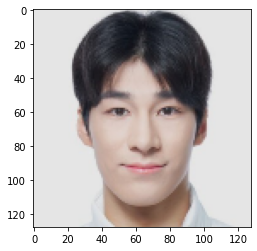

In [28]:
center = [detected_faces[2] - (detected_faces[2] - detected_faces[0]) / 2.0,
          detected_faces[3] - (detected_faces[3] - detected_faces[1]) / 2.0]
#center[1] = center[1] - (detected_faces[3] - detected_faces[1]) * 0.12
scale = (detected_faces[2] - detected_faces[0] + detected_faces[3] - detected_faces[1]) / 195
inp = crop(image, center, scale, resolution=128)
plt.imshow(inp)

Now, save this cropped image and move it to the new directory named "source_img". This image will be used as an input to StarGAN.

In [29]:
import os
import shutil
io.imsave("cropped_image.png", inp)
source_dir = "source_img"
os.makedirs(source_dir, exist_ok=True)
shutil.move("cropped_image.png", f"source_img/input_image.png")

'source_img/input_image.png'

In [30]:
!python generate.py --pretrained-params pretrained_params_on_celebA.h5 --config pretrained_conf_on_celebA.json --test-image-path source_img

2022-02-25 03:23:38,373 [nnabla][INFO]: Initializing CPU extension...
2022-02-25 03:23:38,755 [nnabla][INFO]: Initializing CUDA extension...
2022-02-25 03:23:38,761 [nnabla][INFO]: Initializing cuDNN extension...
Learned attributes choice: ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
Source image: input_image.png
Use 'Black_Hair'?
type yes or no: no
Use 'Blond_Hair'?
type yes or no: yes
Use 'Brown_Hair'?
type yes or no: no
Use 'Male'?
type yes or no: yes
Use 'Young'?
type yes or no: yes
Saved tmp.results/generated_0_Blond_Hair_Male_Young.png.


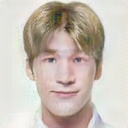

In [31]:
import glob
generated_img = sorted(glob.glob(os.path.join("tmp.results/*.png")), key=os.path.getmtime)[-1]
#print(generated_img)
display(Image(generated_img))